In [45]:
import sys
USING_COLAB = 'google.colab' in sys.modules

if USING_COLAB:
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !pip install -U renderlab
    !pip install -U colabgymrender
    !pip install -U moviepy==0.2.3.5
    !pip install imageio==2.4.1
    !pip install --upgrade AutoROM
    !AutoROM --accept-license
    !pip install gymnasium
    # !pip install gym[classic_control] > /dev/null 2>&1
    !pip install stable_baselines3

import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from copy import deepcopy

from torch.utils.data import DataLoader
from torch import nn
import torch
from gym import spaces

from __future__ import annotations

from collections import defaultdict

import seaborn as sns
from matplotlib.patches import Patch

from tqdm import tqdm, trange

seed = 4756
data_seed = 700

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.10/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


In [46]:
# Setting the seed to ensure reproducability
def reseed(seed, env=None):
    '''
        Sets the seed for reproducibility

        When @param env is provided, also sets the
        random number generataor of the gym environment
        to this particular seed
    '''
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    if env is not None:
        env.unwrapped._np_random = gym.utils.seeding.np_random(seed)[0]

reseed(seed)

In [47]:
def visualize(env_name="Blackjack-v1", algorithm=None, video_name="test", env_args={}):
    """Visualize a policy network for a given algorithm on a single episode

        Args:
            env_name: Name of the gym environment to roll out `algorithm` in, it will be instantiated using gym.make or make_vec_env
            algorithm (PPOActor): Actor whose policy network will be rolled out for the episode. If
            no algorithm is passed in, a random policy will be visualized.
            video_name (str): Name for the mp4 file of the episode that will be saved (omit .mp4). Only used
            when running on local machine.
    """

    def get_action(obs):
        if not algorithm:
            return env.action_space.sample()
        else:
            return algorithm.select_action(obs)

    if USING_COLAB:
        from renderlab import RenderFrame

        directory = './video'
        env_args['render_mode'] = 'rgb_array'
        env = gym.make(env_name, **env_args)
        env = RenderFrame(env, directory)
        obs, info = env.reset()

        for i in range(200):
            action = get_action(obs)
            obs, reward, done, truncate, info = env.step(action)

            if done:
                break

        env.play()
    else:
        import cv2

        video = cv2.VideoWriter(f"{video_name}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 24, (600,400))

        env_args['render_mode'] = 'rgb_array'
        env = gym.make(env_name, **env_args)
        obs, info = env.reset()

        for i in range(500):
            action = get_action(obs)
            res = env.step(action)
            obs, reward, done, truncate, info = res

            if done:
                break

            im = env.render()
            im = im[:,:,::-1]

            video.write(im)

        video.release()
        env.close()
        print(f"Video saved as {video_name}.mp4")

In [48]:
visualize()

  0%|          | 0/3 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1734113613.808223.mp4, 900000 bytes wanted but 0 bytes read,at frame 2/3, at time 0.07/0.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

100%|██████████| 3/3 [00:00<00:00, 109.69it/s]


In [49]:
def evaluate_policy(actor, environment, num_episodes=100, progress=True):
    '''
        Returns the mean trajectory reward of rolling out `actor` on `environment

        Parameters
        - actor: PPOActor instance, defined in Part 1
        - environment: classstable_baselines3.common.vec_env.VecEnv instance
        - num_episodes: total number of trajectories to collect and average over
    '''
    total_rew = 0

    iterate = (trange(num_episodes) if progress else range(num_episodes))
    for _ in iterate:
        obs = environment.reset()
        done = False

        while not done:
            action = actor.select_action(obs)

            next_obs, reward, done, info = environment.step(action)
            total_rew += reward

            obs = next_obs

    return (total_rew / num_episodes).item()

In [61]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env.base_vec_env import VecEnv

hyperparameters = {
    "n_steps": 10000,
    "batch_size": 128,
    "policy_kwargs": {
        "net_arch": {
            "pi": [32, 64, 32],
            "vf": [32, 64, 32],
            "activation_fn": "tanh",
        }
    },
}

In [51]:
class BlackjackWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(BlackjackWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)

    def observation(self, observation):
        return np.array(observation, dtype=np.float32) / np.array([32, 11, 2], dtype=np.float32)

In [52]:
def make_env():
    env = gym.make("Blackjack-v1")
    # print(isinstance(env.observation_space, spaces.Box))
    return BlackjackWrapper(env)

# input_shape = len(env.observation_space)
# # env.observation_space = torch.tensor((float(env.observation_space[0]), float(env.observation_space[1]), float(env.observation_space[2])))
# num_actions = env.action_space.n
# print(input_shape)
# print(num_actions)

In [53]:
from stable_baselines3.common.env_util import make_vec_env

real_vec_env_3 = make_vec_env(make_env, n_envs=3)
real_vec_env_1 = make_vec_env(make_env, n_envs=1)

In [54]:
class PPOActor():
    def __init__(self, ckpt: str=None, environment: VecEnv=None, model=None):
        '''
          Requires environment to be a 1-vectorized environment

          The `ckpt` is a .zip file path that leads to the checkpoint you want
          to use for this particular actor.

          If the `model` variable is provided, then this constructor will store
          that as the internal representing model instead of loading one from the
          checkpoint path

        '''
        assert ckpt is not None or model is not None
        if model is not None:
            self.model = model
            return

        self.model = PPO("MlpPolicy", real_vec_env_3, **hyperparameters)
        self.model = PPO.load(ckpt, environment)


    def select_action(self, obs):
        '''
          Gives the action prediction of this particular actor
        '''
        pred_act, _state = self.model.predict(obs)
        return pred_act

In [55]:
class PPOCallback(BaseCallback):
    def __init__(self, verbose=0, save_path='default', eval_env=None):
        super(PPOCallback, self).__init__(verbose)
        self.rewards = []

        self.save_freq = 120000
        self.min_reward = -np.inf
        self.actor = None
        self.eval_env = eval_env

        self.save_path = save_path

        self.eval_steps = []
        self.eval_rewards = []

    def _init_callback(self) -> None:
        pass

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """

        self.actor = PPOActor(model=self.model)

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """

        episode_info = self.model.ep_info_buffer
        rewards = [ep_info['r'] for ep_info in episode_info]
        mean_rewards = np.mean(rewards)

        self.rewards.append(mean_rewards)


    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: If the callback returns False, training is aborted early.
        """
        if self.eval_env is None:
            return True

        if self.num_timesteps % self.save_freq == 0 and self.num_timesteps != 0:
            mean_reward = evaluate_policy(self.actor, environment=self.eval_env, num_episodes=20)
            print(f'evaluating {self.num_timesteps=}, {mean_reward=}=======')

            self.eval_steps.append(self.num_timesteps)
            self.eval_rewards.append(mean_reward)
            if mean_reward > self.min_reward:
                self.min_reward = mean_reward
                self.model.save(self.save_path)
                print(f'model saved on eval reward: {self.min_reward}')

        return True

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        print(f'model saved on eval reward: {self.min_reward}')

        plt.plot(self.eval_steps, self.eval_rewards, c='red')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('Rewards over Episodes')

        plt.show()
        plt.close()

100%|██████████| 20/20 [00:00<00:00, 550.87it/s]


evaluating self.num_timesteps=120000, mean_reward=-0.15000000596046448=======
model saved on eval reward: -0.15000000596046448


100%|██████████| 20/20 [00:00<00:00, 690.17it/s]


evaluating self.num_timesteps=240000, mean_reward=0.4000000059604645=======
model saved on eval reward: 0.4000000059604645


100%|██████████| 20/20 [00:00<00:00, 413.91it/s]


evaluating self.num_timesteps=360000, mean_reward=-0.30000001192092896=======


100%|██████████| 20/20 [00:00<00:00, 539.54it/s]


evaluating self.num_timesteps=480000, mean_reward=-0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 641.33it/s]


evaluating self.num_timesteps=600000, mean_reward=0.0=======


100%|██████████| 20/20 [00:00<00:00, 590.67it/s]


evaluating self.num_timesteps=720000, mean_reward=-0.25=======


100%|██████████| 20/20 [00:00<00:00, 546.06it/s]


evaluating self.num_timesteps=840000, mean_reward=0.0=======


100%|██████████| 20/20 [00:00<00:00, 564.45it/s]


evaluating self.num_timesteps=960000, mean_reward=0.3499999940395355=======


100%|██████████| 20/20 [00:00<00:00, 587.08it/s]


evaluating self.num_timesteps=1080000, mean_reward=0.30000001192092896=======


100%|██████████| 20/20 [00:00<00:00, 580.38it/s]


evaluating self.num_timesteps=1200000, mean_reward=0.4000000059604645=======


100%|██████████| 20/20 [00:00<00:00, 588.08it/s]


evaluating self.num_timesteps=1320000, mean_reward=-0.44999998807907104=======


100%|██████████| 20/20 [00:00<00:00, 637.17it/s]


evaluating self.num_timesteps=1440000, mean_reward=0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 583.45it/s]


evaluating self.num_timesteps=1560000, mean_reward=0.20000000298023224=======


100%|██████████| 20/20 [00:00<00:00, 492.85it/s]


evaluating self.num_timesteps=1680000, mean_reward=-0.3499999940395355=======


100%|██████████| 20/20 [00:00<00:00, 552.05it/s]


evaluating self.num_timesteps=1800000, mean_reward=0.0=======


100%|██████████| 20/20 [00:00<00:00, 601.36it/s]


evaluating self.num_timesteps=1920000, mean_reward=-0.20000000298023224=======


100%|██████████| 20/20 [00:00<00:00, 574.22it/s]


evaluating self.num_timesteps=2040000, mean_reward=-0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 586.68it/s]


evaluating self.num_timesteps=2160000, mean_reward=-0.25=======


100%|██████████| 20/20 [00:00<00:00, 533.86it/s]


evaluating self.num_timesteps=2280000, mean_reward=-0.10000000149011612=======


100%|██████████| 20/20 [00:00<00:00, 502.19it/s]


evaluating self.num_timesteps=2400000, mean_reward=0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 518.81it/s]


evaluating self.num_timesteps=2520000, mean_reward=0.10000000149011612=======


100%|██████████| 20/20 [00:00<00:00, 716.04it/s]


evaluating self.num_timesteps=2640000, mean_reward=-0.3499999940395355=======


100%|██████████| 20/20 [00:00<00:00, 605.20it/s]


evaluating self.num_timesteps=2760000, mean_reward=-0.30000001192092896=======


100%|██████████| 20/20 [00:00<00:00, 677.19it/s]


evaluating self.num_timesteps=2880000, mean_reward=-0.30000001192092896=======


100%|██████████| 20/20 [00:00<00:00, 655.21it/s]


evaluating self.num_timesteps=3000000, mean_reward=-0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 525.14it/s]


evaluating self.num_timesteps=3120000, mean_reward=0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 632.47it/s]


evaluating self.num_timesteps=3240000, mean_reward=-0.3499999940395355=======


100%|██████████| 20/20 [00:00<00:00, 663.14it/s]


evaluating self.num_timesteps=3360000, mean_reward=0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 653.45it/s]


evaluating self.num_timesteps=3480000, mean_reward=-0.25=======


100%|██████████| 20/20 [00:00<00:00, 642.01it/s]


evaluating self.num_timesteps=3600000, mean_reward=0.25=======


100%|██████████| 20/20 [00:00<00:00, 654.56it/s]


evaluating self.num_timesteps=3720000, mean_reward=0.0=======


100%|██████████| 20/20 [00:00<00:00, 575.67it/s]


evaluating self.num_timesteps=3840000, mean_reward=-0.20000000298023224=======


100%|██████████| 20/20 [00:00<00:00, 613.14it/s]


evaluating self.num_timesteps=3960000, mean_reward=-0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 521.11it/s]


evaluating self.num_timesteps=4080000, mean_reward=-0.25=======


100%|██████████| 20/20 [00:00<00:00, 656.65it/s]


evaluating self.num_timesteps=4200000, mean_reward=-0.20000000298023224=======


100%|██████████| 20/20 [00:00<00:00, 504.35it/s]


evaluating self.num_timesteps=4320000, mean_reward=-0.30000001192092896=======


100%|██████████| 20/20 [00:00<00:00, 616.36it/s]


evaluating self.num_timesteps=4440000, mean_reward=-0.44999998807907104=======


100%|██████████| 20/20 [00:00<00:00, 614.29it/s]


evaluating self.num_timesteps=4560000, mean_reward=0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 607.78it/s]


evaluating self.num_timesteps=4680000, mean_reward=0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 422.88it/s]


evaluating self.num_timesteps=4800000, mean_reward=0.10000000149011612=======


100%|██████████| 20/20 [00:00<00:00, 614.13it/s]


evaluating self.num_timesteps=4920000, mean_reward=0.20000000298023224=======


100%|██████████| 20/20 [00:00<00:00, 640.92it/s]


evaluating self.num_timesteps=5040000, mean_reward=0.25=======


100%|██████████| 20/20 [00:00<00:00, 553.46it/s]


evaluating self.num_timesteps=5160000, mean_reward=0.25=======


100%|██████████| 20/20 [00:00<00:00, 483.56it/s]


evaluating self.num_timesteps=5280000, mean_reward=-0.44999998807907104=======


100%|██████████| 20/20 [00:00<00:00, 631.95it/s]


evaluating self.num_timesteps=5400000, mean_reward=-0.30000001192092896=======


100%|██████████| 20/20 [00:00<00:00, 624.84it/s]


evaluating self.num_timesteps=5520000, mean_reward=0.20000000298023224=======


100%|██████████| 20/20 [00:00<00:00, 451.88it/s]


evaluating self.num_timesteps=5640000, mean_reward=-0.3499999940395355=======


100%|██████████| 20/20 [00:00<00:00, 580.94it/s]


evaluating self.num_timesteps=5760000, mean_reward=-0.30000001192092896=======


100%|██████████| 20/20 [00:00<00:00, 623.55it/s]


evaluating self.num_timesteps=5880000, mean_reward=0.0=======


100%|██████████| 20/20 [00:00<00:00, 577.88it/s]


evaluating self.num_timesteps=6000000, mean_reward=0.25=======


100%|██████████| 20/20 [00:00<00:00, 589.83it/s]


evaluating self.num_timesteps=6120000, mean_reward=0.25=======


100%|██████████| 20/20 [00:00<00:00, 601.94it/s]


evaluating self.num_timesteps=6240000, mean_reward=0.10000000149011612=======


100%|██████████| 20/20 [00:00<00:00, 597.85it/s]


evaluating self.num_timesteps=6360000, mean_reward=0.0=======


100%|██████████| 20/20 [00:00<00:00, 584.89it/s]


evaluating self.num_timesteps=6480000, mean_reward=0.20000000298023224=======


100%|██████████| 20/20 [00:00<00:00, 618.96it/s]


evaluating self.num_timesteps=6600000, mean_reward=0.25=======


100%|██████████| 20/20 [00:00<00:00, 683.60it/s]


evaluating self.num_timesteps=6720000, mean_reward=0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 531.01it/s]


evaluating self.num_timesteps=6840000, mean_reward=0.10000000149011612=======


100%|██████████| 20/20 [00:00<00:00, 619.40it/s]


evaluating self.num_timesteps=6960000, mean_reward=-0.30000001192092896=======


100%|██████████| 20/20 [00:00<00:00, 530.72it/s]


evaluating self.num_timesteps=7080000, mean_reward=0.0=======


100%|██████████| 20/20 [00:00<00:00, 661.57it/s]


evaluating self.num_timesteps=7200000, mean_reward=0.10000000149011612=======


100%|██████████| 20/20 [00:00<00:00, 491.29it/s]


evaluating self.num_timesteps=7320000, mean_reward=-0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 543.26it/s]


evaluating self.num_timesteps=7440000, mean_reward=0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 529.96it/s]


evaluating self.num_timesteps=7560000, mean_reward=0.25=======


100%|██████████| 20/20 [00:00<00:00, 572.77it/s]


evaluating self.num_timesteps=7680000, mean_reward=-0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 499.55it/s]


evaluating self.num_timesteps=7800000, mean_reward=-0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 671.24it/s]


evaluating self.num_timesteps=7920000, mean_reward=-0.25=======


100%|██████████| 20/20 [00:00<00:00, 650.84it/s]


evaluating self.num_timesteps=8040000, mean_reward=0.10000000149011612=======


100%|██████████| 20/20 [00:00<00:00, 439.89it/s]


evaluating self.num_timesteps=8160000, mean_reward=-0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 589.70it/s]


evaluating self.num_timesteps=8280000, mean_reward=-0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 530.04it/s]


evaluating self.num_timesteps=8400000, mean_reward=0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 666.30it/s]


evaluating self.num_timesteps=8520000, mean_reward=-0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 659.87it/s]


evaluating self.num_timesteps=8640000, mean_reward=-0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 613.35it/s]


evaluating self.num_timesteps=8760000, mean_reward=-0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 600.25it/s]


evaluating self.num_timesteps=8880000, mean_reward=0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 459.65it/s]


evaluating self.num_timesteps=9000000, mean_reward=0.10000000149011612=======


100%|██████████| 20/20 [00:00<00:00, 651.54it/s]


evaluating self.num_timesteps=9120000, mean_reward=0.0=======


100%|██████████| 20/20 [00:00<00:00, 579.49it/s]


evaluating self.num_timesteps=9240000, mean_reward=-0.05000000074505806=======


100%|██████████| 20/20 [00:00<00:00, 528.90it/s]


evaluating self.num_timesteps=9360000, mean_reward=-0.20000000298023224=======


100%|██████████| 20/20 [00:00<00:00, 545.64it/s]


evaluating self.num_timesteps=9480000, mean_reward=0.0=======


100%|██████████| 20/20 [00:00<00:00, 584.47it/s]


evaluating self.num_timesteps=9600000, mean_reward=0.15000000596046448=======


100%|██████████| 20/20 [00:00<00:00, 378.43it/s]


evaluating self.num_timesteps=9720000, mean_reward=0.30000001192092896=======


100%|██████████| 20/20 [00:00<00:00, 639.51it/s]


evaluating self.num_timesteps=9840000, mean_reward=0.20000000298023224=======


100%|██████████| 20/20 [00:00<00:00, 633.13it/s]


evaluating self.num_timesteps=9960000, mean_reward=0.05000000074505806=======
model saved on eval reward: 0.4000000059604645


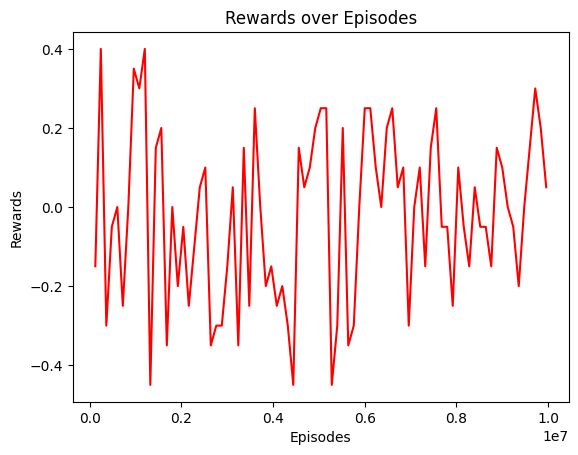

In [62]:
ckpt_path = 'expert'
total_steps = 10000000

reseed(seed)
expert_callback = PPOCallback(save_path=ckpt_path, eval_env=real_vec_env_1)

model = PPO("MlpPolicy", real_vec_env_3, **hyperparameters)
model.learn(total_timesteps=total_steps, callback=expert_callback)

In [63]:
expert = PPOActor(ckpt_path, real_vec_env_1, model)
evaluate_policy(expert, real_vec_env_1)

100%|██████████| 100/100 [00:00<00:00, 600.93it/s]


0.019999999552965164

In [64]:
visualize(algorithm=expert, video_name='expert')

  0%|          | 0/3 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1734125130.9860256.mp4, 900000 bytes wanted but 0 bytes read,at frame 2/3, at time 0.07/0.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

100%|██████████| 3/3 [00:00<00:00, 126.42it/s]
